## Drifters and Cmems data Notebook

### Introduction
This notebook aims to analyze the velocity data from drifters within the tropical Atlantic Ocean. It involves visualizing drifter velocity data, interpolating CMEMS data onto drifter data, and comparing the velocities between drifters and CMEMS.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 12 hours
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047

### Tasks

#### 1. Visualization of Drifter Velocity Data
- Plot the Eastward (ve) and Northward (vn) velocity as a function of time for a selected drifter.

#### 2. Interpolation of CMEMS Data on Drifter Data
- Interpolate CMEMS data onto the time series of the selected drifter data.

#### 3. Comparison between Drifter Velocities and Interpolated CMEMS Velocities
- Visualize the correlation and regression between drifter velocities (ve, vn) and interpolated CMEMS velocities (ugosa, vgosa).
- Plot time series of both drifter velocities and interpolated CMEMS velocities.
- Visualize the difference between the two datasets.

## Import Library


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation

## Read Drifter Data


In [2]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables


In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [4]:
data = {
    'Longitude': lon,
    'Latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,Longitude,Latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data


In [5]:
# Test: Our selected drifter has 1102 observations. However, we will limit it to 158 observations because the coordinates 
# of our CMEMS data are 158 in dimension, and the linear interpolation method we use requires it in this situation.

df_1 = df[0:158] 
df_1

,Longitude,Latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
153,-17.671,-18.700,2023-02-08 06:00:00,-0.11487,-0.00411,25.657
154,-17.695,-18.704,2023-02-08 12:00:00,-0.09986,-0.02095,25.741
155,-17.711,-18.708,2023-02-08 18:00:00,-0.02361,0.00256,25.866
156,-17.705,-18.703,2023-02-09 00:00:00,-0.01014,0.08457,25.758


## Time Series of Eastward (ve) and Northward (vn) Velocity for Our Drifter 

## Case of ve

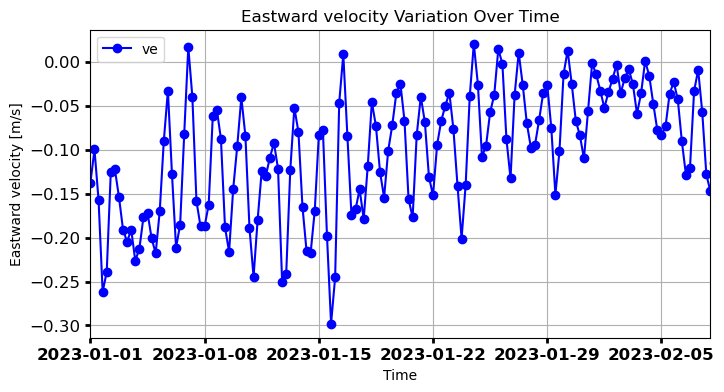

In [6]:
# Assuming you have a DataFrame named df with 'time' and 've' columns

# Step 1: Plotting
plt.figure(figsize=(8, 4))

# Plot ve as a function of time
plt.plot(df_1['time'], df_1['ve'], color='blue', marker='o', linestyle='-')

# Add axis labels and title
plt.legend(['ve'])
plt.xlabel('Time')
plt.ylabel('Eastward velocity [m/s]')
plt.title('Eastward velocity Variation Over Time')

# Add grid
plt.grid(True)

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)

# plt.fill_between([start_date, end_date], ymin, ymax, color='green', alpha=0.3)
plt.savefig("fig7 mode.png")
plt.show()

# Show plot
plt.show()

## Case of vn

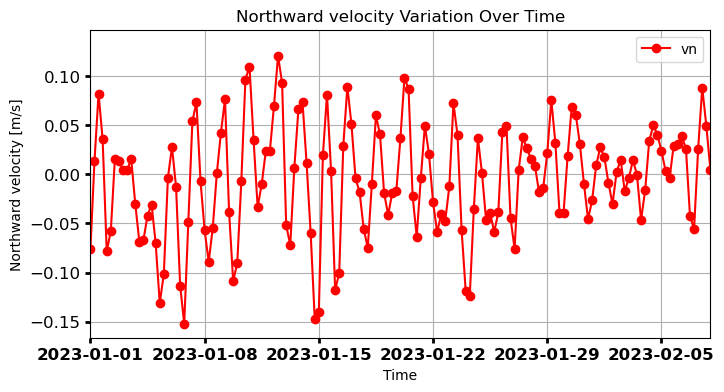

In [7]:
# Assuming you have a DataFrame named df with 'time' and 'vn' columns

# Step 1: Plotting
plt.figure(figsize=(8, 4))

# Plot vn as a function of time
plt.plot(df_1['time'], df_1['vn'], color='red', marker='o', linestyle='-')

# Add axis labels and title
plt.legend(['vn'])
plt.xlabel('Time')
plt.ylabel('Northward velocity [m/s]')
plt.title('Northward velocity Variation Over Time')

# Add grid
plt.grid(True)

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)

# plt.fill_between([start_date, end_date], ymin, ymax, color='green', alpha=0.3)
plt.savefig("fig8 mode.png")
plt.show()

# Show plot
plt.show()

## Case of vn

## In our study zone

## Now Let's Interpolate CMEMS Data to This Drifter Data


## Case of Geostrophic Velocity Anomalies: Zonal Component (ugosa) to Eastward Velocity (ve)


# Interpolation of CMEMS Variable (ugosa) to Drifter Variable (ve)

In this step, we interpolate the ugosa variable from the CMEMS data to the ve variable of the selected drifter.

We utilize the linear interpolation method for this process. The interpolation is performed based on the variables of longitude, latitude, and important timestamps.

This allows us to make comparisons and identify differences between drifter variables and CMEMS variables obtained through interpolations.

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_10768\4172527657.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['ugosa'] = mean_ugosa_2


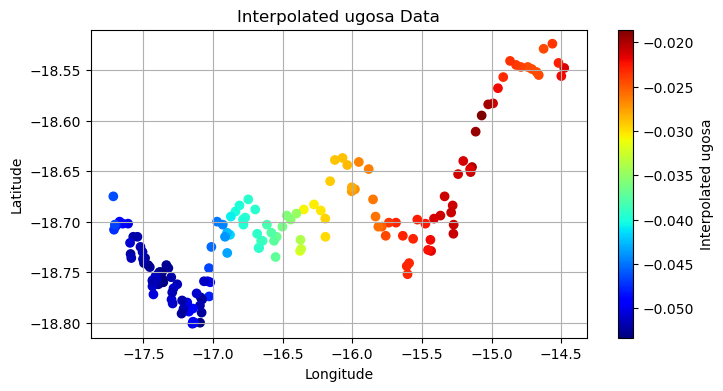

In [9]:
from scipy.interpolate import griddata

# Load your netCDF data
data = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1713524113026.nc')
# reduce the dimention of data frame to have the same result like cmems
# Define your dataframe, assuming it has columns 'longitude', 'latitude' and time
# Replace df with your dataframe variable name and adjust column names accordingly

# Interpolate netCDF data onto the dataframe's coordinates
# Assuming netCDF data has dimensions 'longitude' and 'latitude'
interpolated_data = data.interp(latitude=df_1['Latitude'], longitude=df_1['Longitude'], time=df_1['time'], method='linear')

# Extract interpolated values
interpolated_values = interpolated_data['ugosa'].values

# Add interpolated values to your dataframe
# note that interpolated_variable is a function of time, longitude and latitude. 
# We average over longitude and latitude to have it over time and has a dimension

mean_ugosa_1=np.mean(interpolated_values, axis=1)
mean_ugosa_2=np.mean(mean_ugosa_1, axis=1)
df_1['ugosa'] = mean_ugosa_2

# Plot the interpolated data with continents, rivers, and lakes
plt.figure(figsize=(8, 4))
df_1['Latitude']
# Plot continents in green
# Add your code to plot continents here
# Example: plt.continent()

# Plot rivers
# Add your code to plot rivers here
# Example: plt.rivers()

# Plot lakes
# Add your code to plot lakes here
# Example: plt.lakes()

# Plot interpolated data
plt.scatter(df_1['Longitude'], df_1['Latitude'], c= df_1['ugosa'], cmap='jet', marker='o')

# Add axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated ugosa Data')

# Show the plot
plt.colorbar(label='Interpolated ugosa')
plt.grid(True)
plt.savefig("fig9 mode.png")
plt.show()

## Conversion from Geostrophic Velocity Anomalies: Meridional Component (vgosa) to Eastward Velocity (vn)

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_10768\905166600.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['vgosa'] = mean_vgosa_2


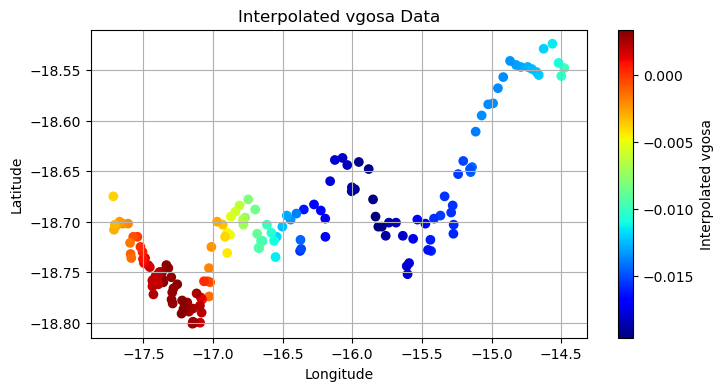

In [10]:
from scipy.interpolate import griddata

# Load your netCDF data
data = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1713524113026.nc')
# reduce the dimention of data frame to have the same result like cmems
# Define your dataframe, assuming it has columns 'longitude', 'latitude' and time
# Replace df with your dataframe variable name and adjust column names accordingly


# Interpolate netCDF data onto the dataframe's coordinates
# Assuming netCDF data has dimensions 'longitude' and 'latitude'
interpolated_data = data.interp(latitude=df_1['Latitude'], longitude=df_1['Longitude'], time=df_1['time'], method='linear')

# Extract interpolated values
interpolated_values = interpolated_data['vgosa'].values

# Add interpolated values to your dataframe
# note that interpolated_variable is a function of time, longitude and latitude. 
# We average over longitude and latitude to have it over time and has a dimension

mean_vgosa_1=np.mean(interpolated_values, axis=1)
mean_vgosa_2=np.mean(mean_vgosa_1, axis=1)
df_1['vgosa'] = mean_vgosa_2

# Plot the interpolated data with continents, rivers, and lakes
plt.figure(figsize=(8, 4))
df_1['Latitude']
# Plot continents in green
# Add your code to plot continents here
# Example: plt.continent()

# Plot rivers
# Add your code to plot rivers here
# Example: plt.rivers()

# Plot lakes
# Add your code to plot lakes here
# Example: plt.lakes()

# Plot interpolated data
plt.scatter(df_1['Longitude'], df_1['Latitude'], c= df_1['vgosa'], cmap='jet', marker='o')

# Add axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated vgosa Data')

# Show the plot
plt.colorbar(label='Interpolated vgosa')
plt.grid(True)
plt.savefig("fig10 mode.png")
plt.show()

## Time Series of Interpolated ugosa


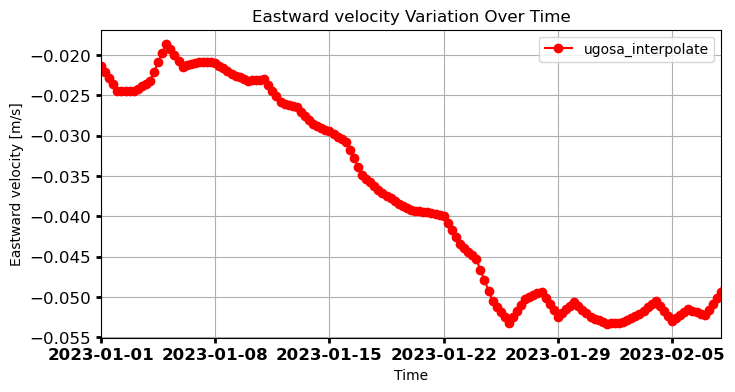

In [11]:
# Assuming you have a DataFrame named df with 'time' and 'vgosa' columns

# Step 1: Plotting
plt.figure(figsize=(8, 4))
df_1=df[0:158]
# Plot ugosa as a function of time
plt.plot(df_1['time'], mean_ugosa_2, color='red', marker='o', linestyle='-')

# Add axis labels and title
plt.legend(['ugosa_interpolate'])
plt.xlabel('Time')
plt.ylabel('Eastward velocity [m/s]')
plt.title('Eastward velocity Variation Over Time')

# Add grid
plt.grid(True)

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)
plt.savefig("fig11 mode.png")

plt.show()
# Show plot
plt.show()

## Time Series of Interpolated vgosa


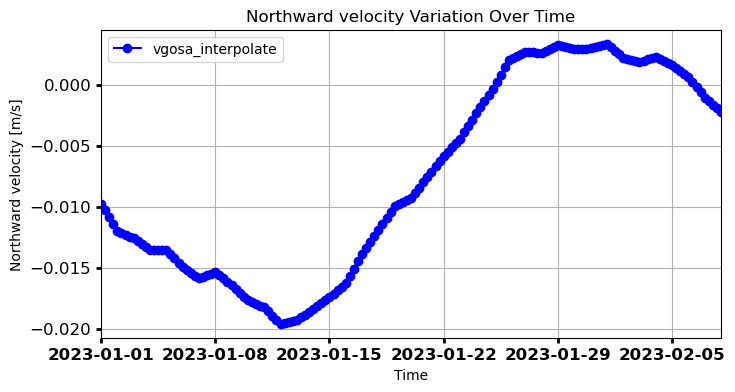

In [12]:
# Assuming you have a DataFrame named df with 'time' and 'vgosa' columns

# Step 1: Plotting
plt.figure(figsize=(8, 4))
df_1=df[0:158]
# Plot ugosa as a function of time
plt.plot(df_1['time'], mean_vgosa_2, color='blue', marker='o', linestyle='-')

# Add axis labels and title
plt.legend(['vgosa_interpolate'])
plt.xlabel('Time')
plt.ylabel('Northward velocity [m/s]')
plt.title('Northward velocity Variation Over Time')

# Add grid
plt.grid(True)

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)
plt.savefig("fig12 mode.png")

plt.show()
# Show plot
plt.show()

## Now Let's Compare Drifter Speeds and Interpolated CMEMS Speeds


## Comparison between ve and Interpolated ugosa


## Using Regression and Correlation


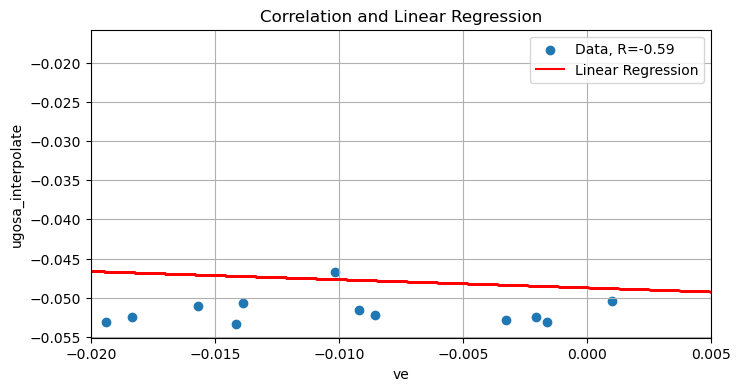

In [13]:
from scipy.stats import linregress
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is just perfect,
# which is subsequently justified by representing the time series. The two curves coincide (see fig14).
# Calculate correlation coefficient
correlation_matrix = np.corrcoef(mean_ugosa_2,df_1['ve'])
correlation = correlation_matrix[0, 1]

# Fit linear regression model

slope, intercept, _, _, _ = linregress( df_1['ve'],mean_ugosa_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(df_1['ve'],mean_ugosa_2, label=f'Data, R={correlation:.2f}')
plt.plot(df_1['ve'], slope*df_1['ve'] + intercept, color='red', label='Linear Regression')
plt.xlabel('ve')
plt.ylabel('ugosa_interpolate')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# Set x-axis limits and tick labels
plt.xlim(-0.02, 0.005)
plt.xticks(np.arange(-0.02, 0.0097, 0.005))
plt.savefig("fig13 mode.png")

plt.show()

## Using Time Series


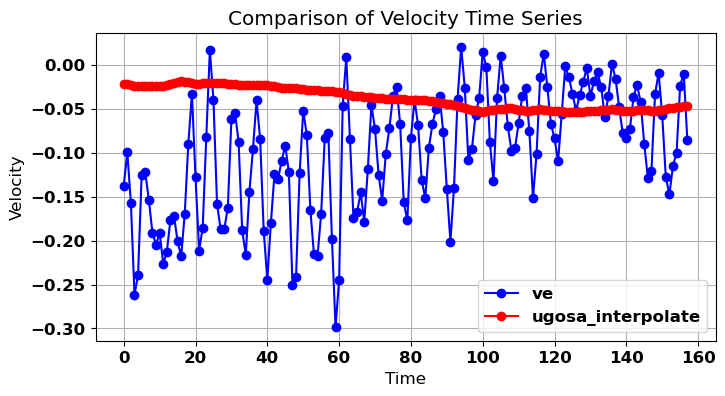

In [14]:
# Plot time series
#
plt.figure(figsize=(8, 4))
plt.plot(df_1['ve'], color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(mean_ugosa_2, color='RED', marker='o', linestyle='-', label='ugosa_interpolate')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')
 

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Comparison of Velocity Time Series')
plt.legend()
plt.grid(True)
plt.savefig("fig14 mode.png")
plt.show()

## Using Difference


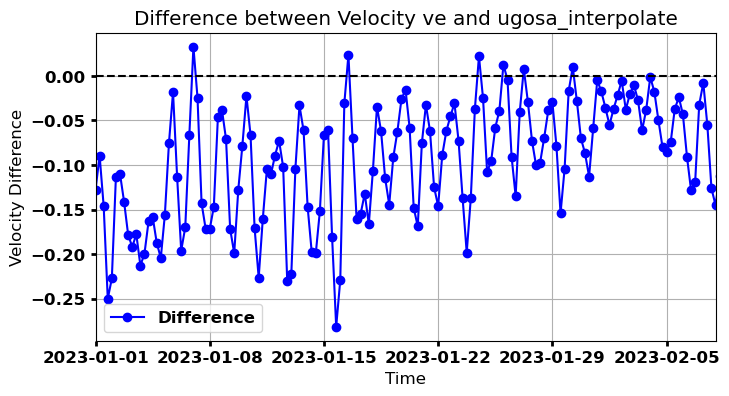

In [15]:
#Subsequently, we notice that the difference between the two curves is null. This justifies the perfect correlation between the two variables.
# Assuming you have already defined $ve$, $ugosa_interpolate$, and `difference`

difference = df_1['ve'] - mean_vgosa_2

plt.figure(figsize=(8, 4))
plt.plot(df_1['time'], difference, label='Difference', color='blue', marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Velocity Difference')
plt.title('Difference between Velocity ve and ugosa_interpolate')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid(True)

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)
plt.savefig("fig15 mode.png")

plt.show()

## Comparison between vn and Interpolated vgosa


## Using Regression and Correlation

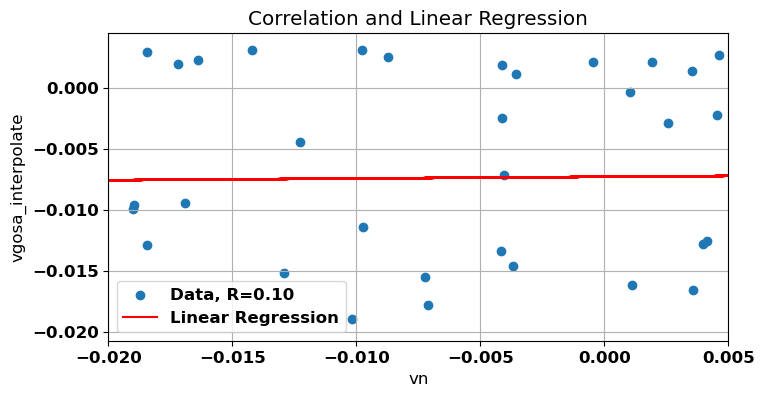

In [24]:
from scipy.stats import linregress
# According to the following, we can note that the correlation between $vn$ and $vgosa_interpolate$ is weak.
# Calculate correlation coefficient
correlation_matrix = np.corrcoef(mean_vgosa_2,df_1['vn'])
correlation = correlation_matrix[0, 1]

# Fit linear regression model

slope, intercept, _, _, _ = linregress( df_1['vn'],mean_vgosa_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(df_1['vn'],mean_vgosa_2, label=f'Data, R={correlation:.2f}')
plt.plot(df_1['vn'], slope*df_1['vn'] + intercept, color='red', label='Linear Regression')
plt.xlabel('vn')
plt.ylabel('vgosa_interpolate')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# Set x-axis limits and tick labels
plt.xlim(-0.02, 0.005)
plt.xticks(np.arange(-0.02, 0.0097, 0.005))
plt.savefig("fig16 mode.png")

plt.show()

## Using Time Series

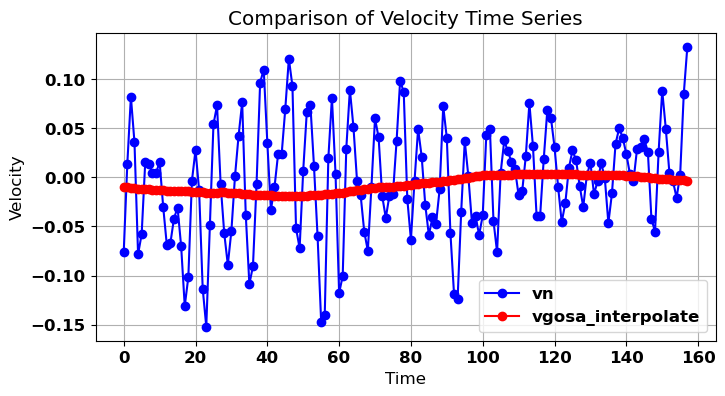

In [42]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(df_1['vn'], color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(mean_vgosa_2, color='RED', marker='o', linestyle='-', label='vgosa_interpolate')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')
 

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Comparison of Velocity Time Series')
plt.legend()
plt.grid(True)
plt.savefig("fig17 mode.png")
plt.show()

 ## Using Difference

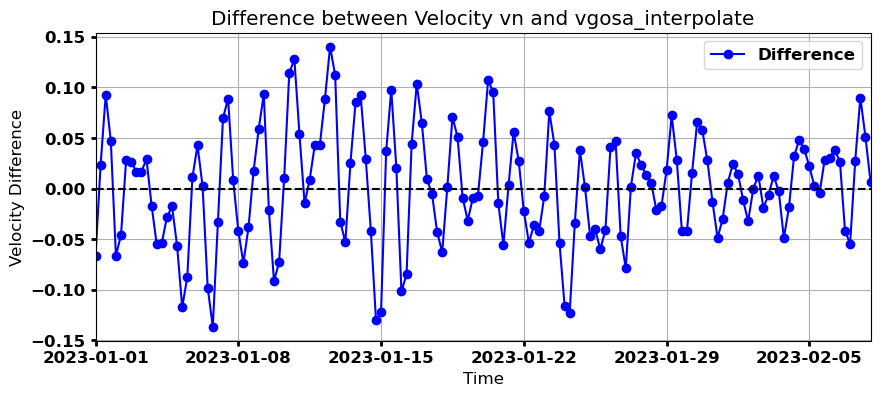

In [43]:
# According to the difference curve, we notice that there is a strong difference between the two variables, 
# and the difference curve is dominated by that of $vn$.

# Assuming you have already defined `vn`, `vgosa_interpolate`, and `difference`

difference = df_1['vn'] - mean_vgosa_2

plt.figure(figsize=(10, 4))
plt.plot(df_1['time'], difference, label='Difference', color='blue', marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Velocity Difference')
plt.title('Difference between Velocity vn and vgosa_interpolate')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid(True)

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)
plt.savefig("fig18 mode.png")

plt.show()